In [29]:
from src.shared_imports import *

plt.style.use("seaborn-v0_8")

In [30]:
df = pd.read_csv("data/processed/gen_sen_merged.csv")
df = df.drop(['HOUR_x', 'DATE_x'], axis=1)
df["DATE_TIME"] = pd.to_datetime(df["DATE_TIME"])
df["DAY"] = df["DATE_TIME"].dt.date

In [31]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68778 entries, 0 to 68777
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   DATE_TIME            68778 non-null  datetime64[ns]
 1   SOURCE_KEY_x         68778 non-null  object        
 2   DC_POWER             68778 non-null  float64       
 3   AC_POWER             68778 non-null  float64       
 4   DAILY_YIELD          68778 non-null  float64       
 5   TOTAL_YIELD          68778 non-null  float64       
 6   INVERTER_EFF         36827 non-null  float64       
 7   AMBIENT_TEMPERATURE  68774 non-null  float64       
 8   MODULE_TEMPERATURE   68774 non-null  float64       
 9   IRRADIATION          68774 non-null  float64       
 10  DAY                  68778 non-null  object        
dtypes: datetime64[ns](1), float64(8), object(2)
memory usage: 5.8+ MB


虽然2.1的线性模型R² ≈ 0.97取得了不错的结果，但是因为光伏发电的过程复杂，很多影响因素是“非线性”的，所以我们需要构建多个Baseline模型，比如XGBoost，比较他们来获取更好的baseline，并且作为最终baseline构建PR时间序列。

In [32]:
df.describe()

,DATE_TIME,DC_POWER,AC_POWER,DAILY_YIELD,TOTAL_YIELD,INVERTER_EFF,AMBIENT_TEMPERATURE,MODULE_TEMPERATURE,IRRADIATION
count,68778,68778.000000,68778.000000,68778.000000,6.877800e+04,36827.000000,68774.000000,68774.000000,68774.000000
mean,2020-06-01 08:02:49.458256896,3147.426211,307.802752,3295.968737,6.978712e+06,0.097719,25.558521,31.244997,0.232305
min,2020-05-15 00:00:00,0.000000,0.000000,0.000000,6.183645e+06,0.095552,20.398505,18.140415,0.000000
25%,2020-05-24 00:45:00,0.000000,0.000000,0.000000,6.512003e+06,0.097579,22.724491,21.123944,0.000000
50%,2020-06-01 14:30:00,429.000000,41.493750,2658.714286,7.146685e+06,0.097845,24.670178,24.818984,0.031620
75%,2020-06-09 20:00:00,6366.964286,623.618750,6274.000000,7.268706e+06,0.098014,27.960429,41.693659,0.454880
max,2020-06-17 23:45:00,14471.125000,1410.950000,9163.000000,7.846821e+06,0.106592,35.252486,65.545714,1.221652
std,NaN,4036.457169,394.396439,3145.178309,4.162720e+05,0.000458,3.361300,12.308283,0.301948


接下来的步骤：
1. 过滤夜间数据以及白天DC=0的数据，属于“异常行为”
2. 构建特征量：
核心物理特征：IRRADIATION MODULE_TEMPERATURE AMBIENT_TEMPERATURE
非线性增强特征：IRR2 = IRRADIATION^2 TEMP2 = MODULE_TEMPERATURE^2 IRR_TEMP = IRRADIATION * MODULE_TEMPERATURE
时间特征：hour = DATE_TIME.hour

In [33]:
#过滤夜间数据以及白天dc=0的异常数据
df = df[(df["DC_POWER"] > 0) & (df["IRRADIATION"] > 0.02)]

#添加特征
df["IRR2"] = df["IRRADIATION"] ** 2
df["TEMP2"] = df["MODULE_TEMPERATURE"] ** 2
df["IRR_TEMP"] = df["IRRADIATION"] * df["MODULE_TEMPERATURE"]

df["hour"] = df["DATE_TIME"].dt.hour

In [34]:
df.describe()

,DATE_TIME,DC_POWER,AC_POWER,DAILY_YIELD,TOTAL_YIELD,INVERTER_EFF,AMBIENT_TEMPERATURE,MODULE_TEMPERATURE,IRRADIATION,IRR2,TEMP2,IRR_TEMP,hour
count,35351,35351.000000,35351.000000,35351.000000,3.535100e+04,35351.000000,35351.000000,35351.000000,35351.000000,35351.000000,35351.000000,35351.000000,35351.000000
mean,2020-06-01 05:09:48.305847040,6118.212285,598.336600,3590.235873,6.979118e+06,0.097769,27.718088,40.424037,0.450151,0.281251,1751.260859,20.992782,11.826257
min,2020-05-15 06:15:00,61.125000,5.912500,0.000000,6.183648e+06,0.095552,20.838399,18.728929,0.020407,0.000416,350.772764,0.462447,6.000000
25%,2020-05-23 18:15:00,2796.687500,274.337500,971.642857,6.514085e+06,0.097616,25.460364,31.234487,0.201037,0.040416,975.593170,6.193751,9.000000
50%,2020-06-01 10:00:00,6217.142857,609.071429,3558.125000,7.146657e+06,0.097860,27.759672,41.007432,0.444573,0.197645,1681.609474,18.348660,12.000000
75%,2020-06-09 13:37:30,9019.116072,881.652679,5843.000000,7.268389e+06,0.098020,29.951886,48.595913,0.662755,0.439244,2361.562728,31.939364,15.000000
max,2020-06-17 18:15:00,14471.125000,1410.950000,9151.000000,7.846816e+06,0.106592,35.252486,65.545714,1.221652,1.492433,4296.240580,72.549113,18.000000
std,NaN,3678.741676,359.007616,2643.757716,4.158848e+05,0.000392,3.139548,10.824113,0.280387,0.281544,882.106126,16.507624,3.492278


In [35]:
from xgboost import XGBRegressor
from sklearn.metrics import r2_score

feature = ["IRRADIATION", "MODULE_TEMPERATURE", "AMBIENT_TEMPERATURE", "IRR2", "TEMP2", "IRR_TEMP", "hour"]
X = df[feature]
y = df["DC_POWER"]

xgb = XGBRegressor(
    n_estimators = 500,
    max_depth = 5,
    learning_rate = 0.05,
    subsample = 0.8,
    colsample_bytree = 0.8,
    random_state = 42
)

xgb.fit(X,y)

y_pred = xgb.predict(X)

r2 = r2_score(y, y_pred)

print("=== XGBoost Baseline Model ===")
print("R² =", r2)

df["DC_BASELINE_XGB"] = y_pred

=== XGBoost Baseline Model ===
R² = 0.9803816915589354


可以看到精度由线性的模型的R² = 0.9646 提升到 R² = 0.9803, 模型精度方面是有显著提升的

In [36]:
df.head()

,DATE_TIME,SOURCE_KEY_x,DC_POWER,AC_POWER,DAILY_YIELD,TOTAL_YIELD,INVERTER_EFF,AMBIENT_TEMPERATURE,MODULE_TEMPERATURE,IRRADIATION,DAY,IRR2,TEMP2,IRR_TEMP,hour,DC_BASELINE_XGB
531,2020-05-15 06:15:00,1BY6WEcLGh8j5v7,278.000000,26.862500,2.625000,6259561.625,0.096628,24.011635,22.353459,0.022282,2020-05-15,0.000496,499.677114,0.498071,6,314.317596
532,2020-05-15 06:15:00,1IF53ai7Xc0U56Y,310.571429,30.014286,3.000000,6183648.000,0.096642,24.011635,22.353459,0.022282,2020-05-15,0.000496,499.677114,0.498071,6,314.317596
533,2020-05-15 06:15:00,3PZuoBAID5Wc2HD,318.625000,30.775000,3.500000,6987762.500,0.096587,24.011635,22.353459,0.022282,2020-05-15,0.000496,499.677114,0.498071,6,314.317596
534,2020-05-15 06:15:00,7JYdWkrLSPkdwr4,316.250000,30.562500,3.500000,7602963.500,0.096640,24.011635,22.353459,0.022282,2020-05-15,0.000496,499.677114,0.498071,6,314.317596
535,2020-05-15 06:15:00,McdE0feGgRqW7Ca,311.428571,30.100000,3.142857,7158967.143,0.096651,24.011635,22.353459,0.022282,2020-05-15,0.000496,499.677114,0.498071,6,314.317596


绘制散点图

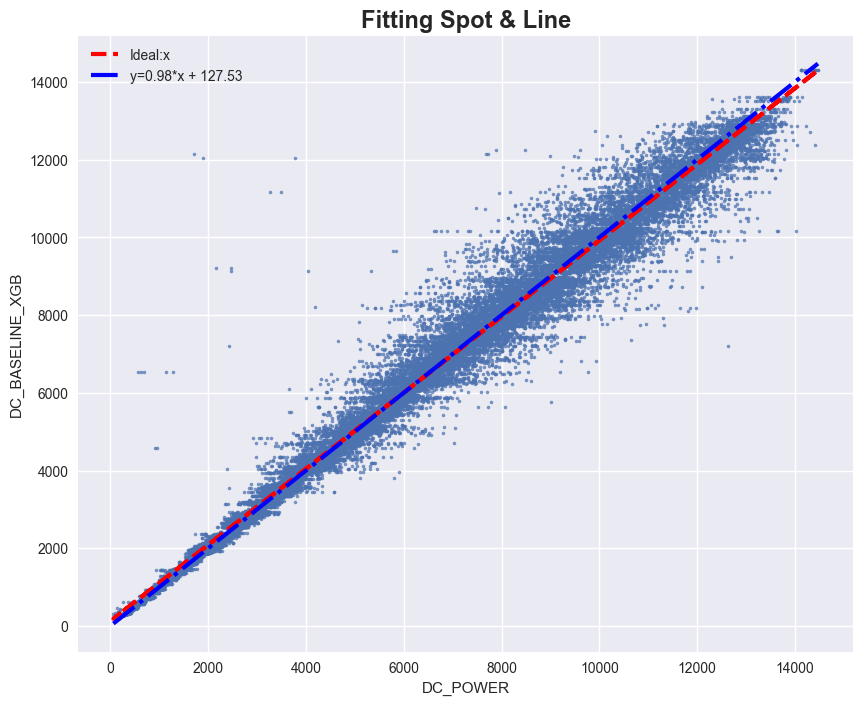

In [48]:
y_true = df["DC_POWER"]
y_pred = df["DC_BASELINE_XGB"]
plt.figure(figsize=(10,8))
plt.scatter(y_true, y_pred, alpha=0.7, s=5, marker="o")
k,b = np.polyfit(y_true, y_pred, 1)
fit_line = k*y_true + b
x_line = np.linspace(y_true.min(),y_true.max(),100)

plt.plot(y_true, fit_line, color="red",linewidth="3", linestyle="--", label= "Ideal:x")
plt.plot(x_line, x_line, color="blue", linewidth="3", linestyle="-.", label= f"y={k:.2f}*x + {b:.2f}")

plt.xlabel("DC_POWER")
plt.ylabel("DC_BASELINE_XGB")
plt.title("Fitting Spot & Line", fontsize=17, weight="bold")
plt.legend()